# **Дополнительное домашнее задание. Логистическая регрессия и решающие деревья**

Суммарно 10 баллов за всю работу. По 5 баллов в каждой части.

Требуется выполнить следующие задания.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import random

from __future__ import annotations

## **Часть 1. Логистическая регрессия (5 баллов)**

**Задание 1 (3 балла)**. Реализуйте логистическую регрессию, обучаемую с помощью двух видов градиенткого спуска:
- полный (по всем данным) градиентный спуск;

- стохастический градиентный спуск;

Во всех пунктах необходимо соблюдать два условия:
- Циклы можно использовать только для итераций градиентного спуска.
- В качестве критерия останова необходимо использовать (одновременно):

    - проверку на евклидову норму разности весов на двух соседних итерациях (например, меньше некоторого малого числа порядка 1e-6), задаваемого параметром `tolerance`;
    - достижение максимального числа итераций (например, 10000), задаваемого параметром `max_iter`.

Чтобы проследить, что оптимизационный процесс действительно сходится, добавьте атрибут класса `loss_history`. В нем после вызова метода `fit` должны содержаться значения функции потерь для всех итераций градиентного спуска, начиная с нулевой.

Инициализировать веса можно случайным образом или нулевым вектором.

In [2]:
from sklearn.base import BaseEstimator
from sklearn.metrics import precision_recall_curve, roc_auc_score, roc_curve, auc, average_precision_score
from sklearn.model_selection import KFold

In [3]:
class MyLogisticRegression(BaseEstimator):
    def __init__(self, gd_type: str = 'stochastic', tolerance: float = 1e-6,
                 max_iter: int = 1000, eta: float = 1e-2,
                 w0: np.array = None) -> None: 
        """
        Аргументы:
          gd_type: вид градиентного спуска ('full' или 'stochastic').

          tolerance: порог для остановки градиетного спуска.

          max_iter: максимальное количество шагов в градиентном спуске.

          eta: скорость обучения (learning rate).

          w0: массив размерности d (d — количество весов в оптимизации).
              Начальные веса.
        """
        self.gd_type = gd_type
        self.tolerance = tolerance
        self.max_iter = max_iter
        self.eta = eta
        self.w0 = w0
        self.w = None
        self.loss_history = None
        
    def sigmoid(self, z):
      return 1 / (1 + np.exp(-z))
    
    def calc_gradient(self, X: np.array, y: np.array) -> np.array:
        """Вычислите градиент функции потерь после каждой итерации.

        Аргументы:
          X: массив размером (n, d), n может быть равно 1, если выбран 'stochastic'.
          y: массив размером (n,).

        Возвращает:
          Массив размером (d,).
          Градиент функции потерь после текущей итерации.
        """
        m = X.shape[0]
        h = self.sigmoid(X @ self.w)
        gradient = X.T @ (h - y) / m
        return gradient
      

    def calc_loss(self, X: np.array, y: np.array) -> float:
        """Вычислите значение функции потерь после каждой итерации.

        Аргументы:
          X: массив размером (n, d).
          y: массив размером (n,).

        Возвращает:
          Значение функции потерь после текущей итерации.
        """
        m = X.shape[0]
        z = X @ self.w
        h = self.sigmoid(z)
        h = np.clip(h, 1e-15, 1 - 1e-15)
        loss = -np.mean(y * np.log(h) + (1 - y) * np.log(1 - h))
        return loss


    def fit(self, X: np.array, y: np.array) -> MyLogisticRegression:
        """Обучаем модель на training данных. Сохраняйте значении функции потерь после каждой итерации.

        Аргументы:
          X: данные на обучение.

          y: целевая переменная.

        Возвращает:
          self: обученный регрессор.
        """
        n_samples, n_features = X.shape
        self.w = self.w0 if self.w0 is not None else np.zeros(n_features)
        self.loss_history = []

        for i in range(self.max_iter):
            if self.gd_type == 'full':
                grad = self.calc_gradient(X, y)
            elif self.gd_type == 'stochastic':
                idx = np.random.randint(0, n_samples)
                grad = self.calc_gradient(X[idx:idx+1], y[idx:idx+1])
            else:
                raise ValueError("gd_type must be 'full' or 'stochastic'")

            w_new = self.w - self.eta * grad
            loss = self.calc_loss(X, y)
            self.loss_history.append(loss)

            if np.linalg.norm(w_new - self.w) < self.tolerance:
                self.w = w_new
                break
            self.w = w_new

        return self


    def predict_proba(self, X: np.array) -> np.array:
        """Вычислите вероятности положительного и отрицательного классов для каждого наблюдения.

        Аргументы:
          X: массив размером (n, d).
             Данные.

        Возвращает:
             Массив размером (n, 2).
             Предсказанные вероятности.
        """
        if self.w is None:
            raise Exception('Not trained yet')
        
        probs = self.sigmoid(X @ self.w)
        return np.vstack([1 - probs, probs]).T


    def predict(self, X: np.array) -> np.array:
        """Предсказание метки класса для каждого наблюдения.

        Аргументы:
          X: массив размером (n, d).
             Данные.

        Возвращает:
             Массив размером (n,).
             Предсказанные метки классов.
        """
        if self.w is None:
            raise Exception('Not trained yet')
          
        probs = self.predict_proba(X)[:, 1]
        return (probs >= 0.5).astype(int)


Далее предполагается, что вы используете собственную реализацию логистической регрессии.
Если с написанием класса возникли проблемы, используйте реализацию sklearn, чтобы не терять баллы за остальные задания.

Сгенерируем искусственные данные.

In [4]:
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split

X, y = make_classification(
    n_samples=10000, n_features=10, n_informative=5, n_redundant=5,
    random_state=999)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=999)

**Задание 2 (1 балл).** Обучите логистическую регрессию на искусственных данных. Нарисуйте изменение лосса во время обучения.

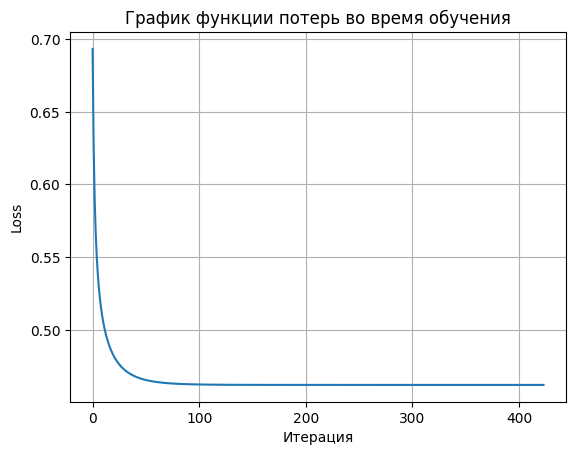

In [5]:
# Обучение модели логистичсекой регрессии на искусственных данных
lg_model = MyLogisticRegression(gd_type='full', eta=0.1, max_iter=500)
lg_model.fit(X_train, y_train)

# График изменения лосса на обучении
plt.plot(lg_model.loss_history)
plt.title('График функции потерь во время обучения')
plt.xlabel("Итерация")
plt.ylabel("Loss")
plt.grid(True)
plt.show()

На тестовой части посчитайте ROC-AUC, PR-AUC. Постройте ROC- и PR-кривые.

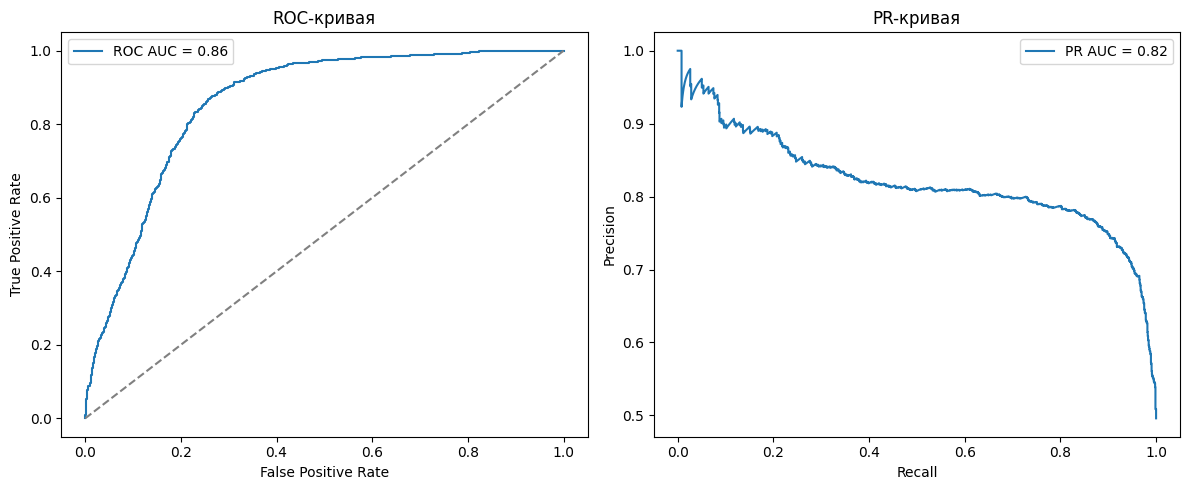

In [6]:
y_probs = lg_model.predict_proba(X_test)[:, 1]  # предсказываем вероятности 
roc_auc = roc_auc_score(y_test, y_probs)  # считаем roc_auc метрику
precision, recall, _ = precision_recall_curve(y_test, y_probs)  # считаем precision и recall метрики
pr_auc = auc(recall, precision)  # считаем auc 

fpr, tpr, _ = roc_curve(y_test, y_probs)  # построение ROC-кривой

# Построение графика
plt.figure(figsize=(12, 5))  
plt.subplot(1, 2, 1)
plt.plot(fpr, tpr, label=f"ROC AUC = {roc_auc:.2f}")
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.title("ROC-кривая")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(recall, precision, label=f"PR AUC = {pr_auc:.2f}")
plt.title("PR-кривая")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.legend()

plt.tight_layout()
plt.show()


**Задание 3 (1 балл).** Оцените ошибку ROC-AUC и PR-AUC вашей модели при помощи K-fold кросс-валидации.  

In [7]:
# K-Fold кросс-валидация
kf_model = KFold(n_splits=5, shuffle=True, random_state=42)

# Инициализация списков для метрик
roc_auc_scores = []
pr_auc_scores = []

# Цикл по фолдам
for train_index, val_index in kf_model.split(X):
    
    # Подмножество обучающих и валидационных данных для текущего фолда
    X_train_k, X_val_k = X[train_index], X[val_index]
    y_train_k, y_val_k = y[train_index], y[val_index]

    # Обучение модели логистической регрессии
    lg_k_fold_model = MyLogisticRegression(gd_type='full', eta=0.1, max_iter=500)
    lg_k_fold_model.fit(X_train_k, y_train_k)

    # Предсказание вероятностей принадлежности к классу 1
    y_proba_k = lg_k_fold_model.predict_proba(X_val_k)[:, 1]

    # Подсчет и сохранение метрик
    roc_auc_scores.append(roc_auc_score(y_val_k, y_proba_k))
    pr_auc_scores.append(average_precision_score(y_val_k, y_proba_k))

roc_auc_scores, pr_auc_scores, np.mean(roc_auc_scores), np.mean(pr_auc_scores)

# Вывод результатов кросс-валидации
for i, (roc, pr) in enumerate(zip(roc_auc_scores, pr_auc_scores), 1):
    print(f"Фолд {i}: ROC-AUC = {roc:.4f}, PR-AUC = {pr:.4f}")

print("\nСредние значения по 5 фолдам:")
print(f"Средний ROC-AUC: {np.mean(roc_auc_scores):.4f}")
print(f"Средний PR-AUC : {np.mean(pr_auc_scores):.4f}")


Фолд 1: ROC-AUC = 0.8728, PR-AUC = 0.8473
Фолд 2: ROC-AUC = 0.8633, PR-AUC = 0.8363
Фолд 3: ROC-AUC = 0.8552, PR-AUC = 0.8139
Фолд 4: ROC-AUC = 0.8688, PR-AUC = 0.8463
Фолд 5: ROC-AUC = 0.8452, PR-AUC = 0.8160

Средние значения по 5 фолдам:
Средний ROC-AUC: 0.8611
Средний PR-AUC : 0.8320


## **Часть 2. Решающие деревья (5 баллов)**

Здесь требуется реализовать разбиение элементов выборки в вершине дерева.

$R_m$ — множество объектов в разбиваемой вершине, $j$ — номер признака, по которому происходит разбиение, $t$ — порог разбиения.

Критерий ошибки:

$$
Q(R_m, j, t) = \frac{|R_\ell|}{|R_m|}H(R_\ell) + \frac{|R_r|}{|R_m|}H(R_r) \to \min_{j, t}
$$

$R_\ell$ — множество объектов в левом поддереве, $R_r$ — множество объектов в правом поддереве.

$H(R)$ — критерий информативности, с помощью которого можно оценить качество распределения целевой переменной среди объектов множества $R$.

In [21]:
from typing import Iterable, List, Tuple

Так как Boston Dataset с недавних пор отсутствует в sklearn, то ниже реализован способ загрузки данного датасета из другого источника.

In [9]:
# `load_boston` has been removed from scikit-learn since version 1.2.

#from sklearn.datasets import load_boston
#boston = load_boston()

In [10]:
#!wget -i https://github.com/scikit-learn/scikit-learn/blob/main/sklearn/datasets/data/boston_house_prices.csv


In [11]:
data = pd.read_csv('data/boston_house_prices.csv',  sep="\s+")

**Data Set Characteristics:**  

    :Number of Instances: 506

    :Number of Attributes: 13 numeric/categorical predictive. Median Value (attribute 14) is usually the target.

    :Attribute Information (in order):
        - CRIM     per capita crime rate by town
        - ZN       proportion of residential land zoned for lots over 25,000 sq.ft.
        - INDUS    proportion of non-retail business acres per town
        - CHAS     Charles River dummy variable (= 1 if tract bounds river; 0 otherwise)
        - NOX      nitric oxides concentration (parts per 10 million)
        - RM       average number of rooms per dwelling
        - AGE      proportion of owner-occupied units built prior to 1940
        - DIS      weighted distances to five Boston employment centres
        - RAD      index of accessibility to radial highways
        - TAX      full-value property-tax rate per $10,000
        - PTRATIO  pupil-teacher ratio by town
        - B        1000(Bk - 0.63)^2 where Bk is the proportion of blacks by town
        - LSTAT    % lower status of the population
        - MEDV     Median value of owner-occupied homes in $1000's

    :Missing Attribute Values: None

    :Creator: Harrison, D. and Rubinfeld, D.L.

This is a copy of UCI ML housing dataset.
https://archive.ics.uci.edu/ml/machine-learning-databases/housing/

This dataset was taken from the StatLib library which is maintained at Carnegie Mellon University.

The Boston house-price data of Harrison, D. and Rubinfeld, D.L. 'Hedonic
prices and the demand for clean air', J. Environ. Economics & Management,
vol.5, 81-102, 1978.   Used in Belsley, Kuh & Welsch, 'Regression diagnostics
...', Wiley, 1980.   N.B. Various transformations are used in the table on
pages 244-261 of the latter.

The Boston house-price data has been used in many machine learning papers that address regression
problems.   
     
.. topic:: References

   - Belsley, Kuh & Welsch, 'Regression diagnostics: Identifying Influential Data and Sources of Collinearity', Wiley, 1980. 244-261.
   - Quinlan,R. (1993). Combining Instance-Based and Model-Based Learning. In Proceedings on the Tenth International Conference of Machine Learning, 236-243, University of Massachusetts, Amherst. Morgan Kaufmann.



In [24]:
data_url = "http://lib.stat.cmu.edu/datasets/boston"
raw_df = pd.read_csv(data_url, sep="\s+", skiprows=22, header=None)
data = np.hstack([raw_df.values[::2, :], raw_df.values[1::2, :2]])
target = raw_df.values[1::2, 2]

In [25]:
feature_names = ['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD', 'TAX', 'PTRATIO', 'B', 'LSTAT']

X = pd.DataFrame(data, columns=feature_names, index=range(len(data)))
y = pd.DataFrame(target, columns=['MEDV'], index=range(len(target)))

X['target'] = y

In [26]:
X_train, X_test = train_test_split(X, test_size=0.25, random_state=999)

In [27]:
X_train

/Users/nadezdaoskina/.pyenv/versions/3.10.9/lib/python3.10/site-packages/IPython/core/formatters.py:342: FutureWarning: Index.format is deprecated and will be removed in a future version. Convert using index.astype(str) or index.map(formatter) instead.
  return method()


,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,target
232,0.57529,0.0,6.20,0.0,0.507,8.337,73.3,3.8384,8.0,307.0,17.4,385.91,2.47,41.7
500,0.22438,0.0,9.69,0.0,0.585,6.027,79.7,2.4982,6.0,391.0,19.2,396.90,14.33,16.8
361,3.83684,0.0,18.10,0.0,0.770,6.251,91.1,2.2955,24.0,666.0,20.2,350.65,14.19,19.9
317,0.24522,0.0,9.90,0.0,0.544,5.782,71.7,4.0317,4.0,304.0,18.4,396.90,15.94,19.8
499,0.17783,0.0,9.69,0.0,0.585,5.569,73.5,2.3999,6.0,391.0,19.2,395.77,15.10,17.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
200,0.01778,95.0,1.47,0.0,0.403,7.135,13.9,7.6534,3.0,402.0,17.0,384.30,4.45,32.9
481,5.70818,0.0,18.10,0.0,0.532,6.750,74.9,3.3317,24.0,666.0,20.2,393.07,7.74,23.7
357,3.84970,0.0,18.10,1.0,0.770,6.395,91.0,2.5052,24.0,666.0,20.2,391.34,13.27,21.7
348,0.01501,80.0,2.01,0.0,0.435,6.635,29.7,8.3440,4.0,280.0,17.0,390.94,5.99,24.5


**Задание 1 (1 балл)**. Реализуйте подсчет критерия ошибки. Для этого реализуйте функции для подсчета значения критерия информативности, а также для разбиения вершины.

In [15]:
def H(R: np.array) -> float:
    """
    Вычислить критерий информативности (impurity criterion) для фиксированного набора объектов R.
    Предполагается, что последний столбец содержить целевую переменную.
    """
    if len(R) == 0:
        return 0.0
    
    y = R[:, -1]
    
    return np.var(y)


def split_node(R_m: np.array, feature: str, t: float) -> Iterable[np.array]:
    """
    Разделить фиксированный набор объектов R_m с заданным признаком (номером признака) и пороговым значением t.
    """
    feature_idx = feature_names.index(feature)
    left = R_m[R_m[:, feature_idx] <= t]
    right = R_m[R_m[:, feature_idx] > t]
    
    return left, right


def q_error(R_m: np.array, feature: str, t: float) -> float:
    """
    Вычислить критерий ошибки для заданных параметров разделения.
    """    
    R_left, R_right = split_node(R_m, feature, t)
    total_len = len(R_m)
    q = (len(R_left) / total_len) * H(R_left) + (len(R_right) / total_len) * H(R_right)
    
    return q
    

**Задание 2 (1 балл)**. Переберите все возможные разбиения обучающей выборки по одному из признаков и постройте график критерия ошибки в зависимости от значения порога.

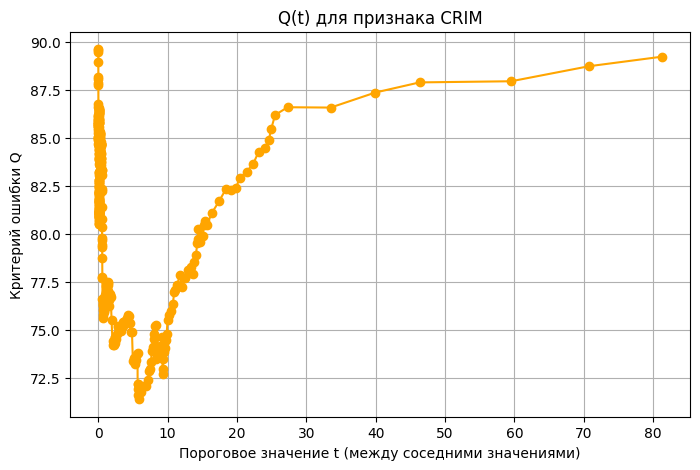

In [16]:
train_data = X_train.values
feature = 'CRIM'

# Получаем отсортированные уникальные значения
values = np.sort(np.unique(X_train[feature].values))

# Вычисляем пороги как среднее между отсортированными в порядке возрастания уникальными значения признака
thresholds = (values[:-1] + values[1:]) / 2

# Считаем Q(t) для каждого порога
q_values = [q_error(train_data, feature, t) for t in thresholds]

# Строим график
plt.figure(figsize=(8, 5))
plt.plot(thresholds, q_values, marker='o', color='orange')
plt.title(f"Q(t) для признака {feature}")
plt.xlabel("Пороговое значение t (между соседними значениями)")
plt.ylabel("Критерий ошибки Q")
plt.grid(True)
plt.show()

**Задание 3  (1 балл)**. Напишите функцию, находящую оптимальное разбиение данной вершины по данному признаку.

In [17]:
def get_optimal_split(R_m: np.array, feature: str) -> Tuple[float, List[float]]:
    """
    Найти оптимальный порог t для заданного признака feature в вершине R_m.
    
    Возвращает:
        - Значение порога t, минимизирующее Q
        - Список всех значений Q для построения графика
    """
    
    feature_idx = feature_names.index(feature)
    values = np.sort(np.unique(R_m[:, feature_idx]))
    
    # Список всех возможных порогов — между уникальными значениями
    thresholds = (values[:-1] + values[1:]) / 2

    # Считаем Q для каждого порога
    q_values = [q_error(R_m, feature, t) for t in thresholds]

    # Ищем минимальное Q и соответствующий порог
    min_idx = np.argmin(q_values)
    best_threshold = thresholds[min_idx]

    return best_threshold, q_values


**Задание 4  (1 балл)**. Для первого разбиения найдите признак, показывающий наилучшее качество. Каков порог разбиения и значение качества? Постройте график критерия ошибки для данного признака в зависимости от значения порога.

In [18]:
# Функция для порогов как среднее между уникальными значениями
def find_thresholds(feature_values: np.array) -> np.array:
    unique_values = np.unique(feature_values)
    
    if len(unique_values) < 2:
        return np.array([])  
    
    thresholds = (unique_values[:-1] + unique_values[1:]) / 2
    
    return thresholds


Лучший признак: RM
Лучший порог разбиения: 6.8375
Минимальное значение Q: 49.3809


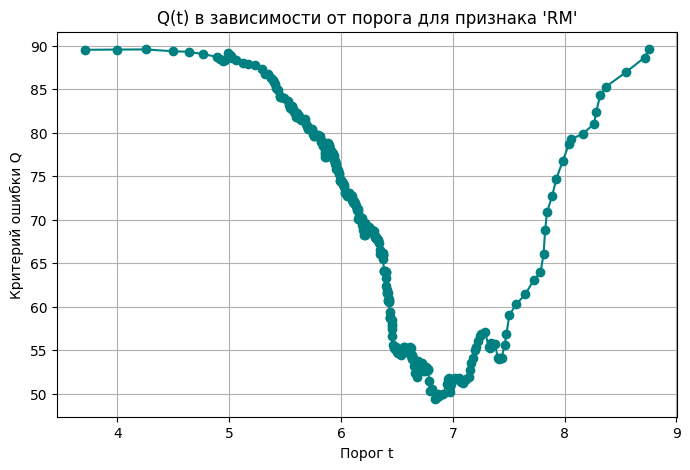

In [19]:
# Стартовые значения для разбиения
best_q = float('inf')
best_feature = None
best_threshold = None
best_q_values = None
best_thresholds = None


# Проходимся по каждому признаку и ищем оптимальный порог разбиения
for feature in feature_names:
    feature_idx = feature_names.index(feature)
    best_t, q_values = get_optimal_split(train_data, feature)

    # Если нашли новый оптимальный порог, то переопределяем переменные
    if q_values and min(q_values) < best_q:
        best_q = min(q_values)
        best_feature = feature
        best_threshold = best_t
        best_q_values = q_values
        best_thresholds = find_thresholds(train_data[:, feature_idx])


# Выводим результат
print(f"Лучший признак: {best_feature}")
print(f"Лучший порог разбиения: {best_threshold}")
print(f"Минимальное значение Q: {best_q:.4f}")

# Строим график
plt.figure(figsize=(8, 5))
plt.plot(best_thresholds, best_q_values, marker='o', color='teal')
plt.title(f"Q(t) в зависимости от порога для признака '{best_feature}'")
plt.xlabel("Порог t")
plt.ylabel("Критерий ошибки Q")
plt.grid(True)
plt.show()


 **Задание 5 (1 балл)**. Изобразите разбиение визуально. Для этого постройте диаграмму рассеяния целевой переменной в зависимости от значения входного признака. Далее изобразите вертикальную линию, соответствующую порогу разбиения.

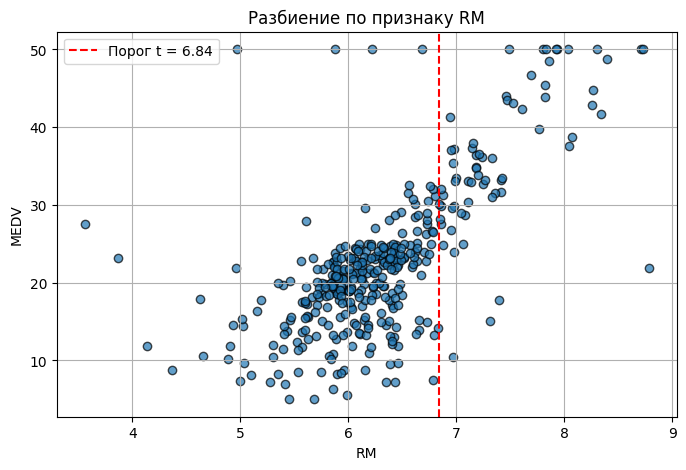

In [20]:
# Изобразим разбиение визуально
feature_index = feature_names.index(best_feature)

x_vals = train_data[:, feature_index]
y_vals = train_data[:, -1]

plt.figure(figsize=(8, 5))
plt.scatter(x_vals, y_vals, alpha=0.7, edgecolor='k')
plt.axvline(best_threshold, color='red', linestyle='--', label=f'Порог t = {best_threshold:.2f}')
plt.title(f"Разбиение по признаку {best_feature}")
plt.xlabel(best_feature)
plt.ylabel("MEDV")
plt.legend()
plt.grid(True)
plt.show()
